<a href="https://colab.research.google.com/github/TTB-gif/-TTB-gif--DataScience-GenAI-Submissions/blob/main/Copy_of_6_02_DNN_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 6.02 Dense Neural Network (with PyTorch)
This will expand on our logistic regression example and take us through building our first neural network. If you haven't already, be sure to check (and if neccessary) switch to GPU processing by clicking Runtime > Change runtime type and selecting GPU. We can test this has worked with the following code:

In [ ]:
import torch

# Check for GPU availability
print("Num GPUs Available: ", torch.cuda.device_count())

Num GPUs Available:  1


Hopefully your code shows you have 1 GPU available! Next let's get some data. We'll start with another in-built dataset:

In [ ]:
# upload an in-built Python (OK semi-in-built) dataset
from sklearn.datasets import load_diabetes

import pandas as pd
import numpy as np

# import the data
data = load_diabetes()
data

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

We are working on a regression problem, with "structured" data which has already been cleaned and normalised. We can skip the usual cleaning/engineering steps. However, we do need to get the data into PyTorch:

In [ ]:
# Convert data to PyTorch tensors
X = torch.tensor(data.data, dtype=torch.float32)
y = torch.tensor(data.target, dtype=torch.float32).reshape(-1, 1) # Reshape y to be a column vector

Now our data is stored in tensors we can do train/test splitting as before (in fact we can use sklearn as before):

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([353, 10]) torch.Size([353, 1])
torch.Size([89, 10]) torch.Size([89, 1])


Now we can set up our batches for training. As we have a nice round 400 let's go with batches of 50 (8 batches in total). We'll also seperate the features and labels:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

Now its time to build our model. We'll keep it simple ... a model with an input layer of 10 features and then 2x _Dense_ (fully connected) layers each with 5 neurons and ReLU activation. Our output layer will be size=1 given this is a regression problem and we want a single value output per prediction.

This will be easier to understand if you have read through the logistic regression tutorial.

In [ ]:
import torch
import torch.nn as nn

# Define the model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        # we'll set up the layers as a sequence using nn.Sequential
        self.layers = nn.Sequential(

            # first layer will be a linear layer that has 5x neurons
            # (5x sets of linear regression)
            # the layer takes the 10 features as input (i.e. 10, 5)
            nn.Linear(10, 5),

            nn.ReLU(), # ReLU activation

            # second linear layer again has 5 neurons
            # this time taking the input as the output of the last layer
            # (which had 5x neurons)
            nn.Linear(5, 5),

            nn.ReLU(), # ReLU again

            # last linear layer takes the output from the previous 5 neurons
            # this time its a single output with no activation
            # i.e. this is the predicitons (regression)
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x) # pass the data through the layers

As before we need to create a model object, specify the loss (criterion) and an optimiser (which we cover next week):

In [ ]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model = DiabetesModel()
criterion = nn.MSELoss() # MSE loss function
optimiser = optim.Adam(model.parameters(), lr=0.001)

Now we can train the model. Again, the logistic regression tutorial (6.01) may help you undertstand this:

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop (example - you'll likely want to add more epochs)
epochs = 100 # 100 epochs

for epoch in range(epochs):
  # use the train_loader to pass the inputs (x) and targets (y)
  for inputs, targets in train_loader:
    # pass to the GPU (hopefully)
    inputs, targets = inputs.to(device), targets.to(device)

    # pass model to GPU as well
    model.to(device)

    model.train() # put the model object in train mode
    optimiser.zero_grad() # reset the gradiants
    outputs = model(inputs) # create outputs
    loss = criterion(outputs, targets) # compare with Y to get loss
    loss.backward() # backpropogate the loss (next week)
    optimiser.step() # # update the parameters based on this round of training

  # every 10 steps we will print out the current loss
    if (epoch+1) % 10 == 0: # modular arithmetic
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {round(loss.item(), 4)}')

Epoch [10/100], Loss: 23482.4785
Epoch [10/100], Loss: 28325.6074
Epoch [10/100], Loss: 27082.4492
Epoch [10/100], Loss: 30652.3184
Epoch [10/100], Loss: 37069.3008
Epoch [10/100], Loss: 28713.5664
Epoch [10/100], Loss: 31473.2402
Epoch [10/100], Loss: 51110.668
Epoch [20/100], Loss: 21681.4961
Epoch [20/100], Loss: 27517.4863
Epoch [20/100], Loss: 31272.2148
Epoch [20/100], Loss: 33063.9023
Epoch [20/100], Loss: 30097.2188
Epoch [20/100], Loss: 33988.0039
Epoch [20/100], Loss: 30059.0898
Epoch [20/100], Loss: 27347.248
Epoch [30/100], Loss: 23959.1953
Epoch [30/100], Loss: 34834.1641
Epoch [30/100], Loss: 33443.7852
Epoch [30/100], Loss: 25661.3711
Epoch [30/100], Loss: 25740.0312
Epoch [30/100], Loss: 24080.9062
Epoch [30/100], Loss: 39501.2578
Epoch [30/100], Loss: 23755.8125
Epoch [40/100], Loss: 31736.1035
Epoch [40/100], Loss: 28089.2598
Epoch [40/100], Loss: 30788.3613
Epoch [40/100], Loss: 29111.6074
Epoch [40/100], Loss: 32704.7109
Epoch [40/100], Loss: 30916.4727
Epoch [40/10

We can see loss is significantly lower at the end than it was at the start. However, it is also bouncing around a little still which suggests the model needs more training (100 epochs is not a lot in deep learning terms). However, let's evaluate as before:

In [ ]:
# Evaluation (example)
model.eval() # testing mode
mse_values = [] # collect the MSE scores

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs) # predict the test data

        # Calculate Mean Squared Error
        mse = criterion(outputs, targets) # calcualte mse for the batch
        mse_values.append(mse.item()) # add to the list of MSE values

# Calculate and print the average MSE
avg_mse = np.mean(mse_values)
print(f"Average MSE on test set: {avg_mse}")

Average MSE on test set: 23460.009765625


MSE looks expected given training (no obvious sign of overfitting). However, we probably can get better results with tuning and more epochs.

Let's run the loop again a little differently to collect the predicted values (y_hat) and actuals (y) and add them to a dataset for comparions:

In [ ]:
# Evaluation
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

# Create DataFrame
results_df = pd.DataFrame({'Predicted': np.array(predictions).flatten(), 'Actual': np.array(actuals).flatten()})
results_df

,Predicted,Actual
0,10.279951,219.0
1,9.693555,70.0
2,10.249487,202.0
3,11.595583,230.0
4,9.838078,111.0
...,...,...
84,9.008944,153.0
85,8.523270,98.0
86,7.883860,37.0
87,8.095680,63.0


Side-by-side, they don't look great. Can you improve them?

<br><br>

## EXERCISE #1
Try increasing the number of epochs to 1,000 (when the model is fairly well trained then the results printed for each 10x epochs will be fairly stable and not change much). Does this give better results?

<br><br>

## EXERCISE #2 (optional)
Try experimenting with the architecture (number of neurons and/or number of layers). Can we reach an optimal architecture?

# Task
The user wants to evaluate the impact of increasing the training epochs on the model's performance. To address this, I will perform the following steps:

1.  **Store Initial MSE**: Save the currently calculated average MSE from the 100-epoch training as `initial_avg_mse`.
2.  **Re-initialize Model for New Training**: Recreate the `DiabetesModel` and re-initialize the `criterion` and `optimizer` to ensure a fresh training start.
3.  **Train Model with 1000 Epochs**: Retrain the model for 1000 epochs using the same data loaders, criterion, and optimizer.
4.  **Evaluate Model with 1000 Epochs**: Evaluate the newly trained model on the test set and calculate the average MSE. Store this as `new_avg_mse`.
5.  **Compare MSE with Bar Chart**: Generate a bar chart comparing `initial_avg_mse` and `new_avg_mse` to visually represent the change in performance.
6.  **Summarize Findings**: Conclude whether increasing the epochs improved the model's performance based on the MSE comparison.

This plan will directly address "EXERCISE #1" by training the model with 1000 epochs and comparing the results.

Here's the code for the plan:
```python
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Store Initial MSE ---
# The initial average MSE from the previous run (100 epochs) was:
initial_avg_mse = 23460.009765625
print(f"Initial Average MSE (100 epochs): {initial_avg_mse}")

# --- Data Preparation (Re-running relevant cells to ensure consistency) ---
data = load_diabetes()
X = torch.tensor(data.data, dtype=torch.float32)
y = torch.tensor(data.target, dtype=torch.float32).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Define the model (same as before)
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
    def forward(self, x):
        return self.layers(x)

# --- 2. Re-initialize Model for New Training ---
model = DiabetesModel()
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- 3. Train Model with 1000 Epochs ---
epochs_1000 = 1000 # Increased epochs

print("\nStarting training for 1000 epochs...")
for epoch in range(epochs_1000):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        model.train()
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()

    if (epoch + 1) % 100 == 0: # Print loss every 100 epochs
        print(f'Epoch [{epoch + 1}/{epochs_1000}], Loss: {round(loss.item(), 4)}')

# --- 4. Evaluate Model with 1000 Epochs ---
model.eval()
mse_values_1000 = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        mse = criterion(outputs, targets)
        mse_values_1000.append(mse.item())

new_avg_mse = np.mean(mse_values_1000)
print(f"\nAverage MSE on test set (1000 epochs): {new_avg_mse}")

# --- 5. Compare MSE with Bar Chart ---
mse_labels = ['100 Epochs', '1000 Epochs']
mse_scores = [initial_avg_mse, new_avg_mse]

plt.figure(figsize=(8, 6))
plt.bar(mse_labels, mse_scores, color=['skyblue', 'lightcoral'])
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Comparison of Model Performance (MSE) after 100 vs 1000 Epochs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 6. Summarize Findings ---
print("\n--- Summary of Findings ---")
print(f"Initial Average MSE (100 epochs): {initial_avg_mse}")
print(f"New Average MSE (1000 epochs): {new_avg_mse}")

if new_avg_mse < initial_avg_mse:
    print(f"Increasing epochs from 100 to 1000 significantly improved the model's performance, reducing the MSE by {initial_avg_mse - new_avg_mse:.2f}.")
elif new_avg_mse > initial_avg_mse:
    print(f"Increasing epochs from 100 to 1000 led to a slight increase in MSE, indicating potential overfitting or no further improvement.")
else:
    print("Increasing epochs did not significantly change the model's performance.")
```

## Train Model with 1000 Epochs

### Subtask:
Retrain the `DiabetesModel` for 1000 epochs using the existing data loaders, criterion, and optimizer.


**Reasoning**:
I will create a code block to retrain the `DiabetesModel` for 1000 epochs, following the specified instructions for the training loop, including moving data and model to the device, calculating loss, performing backpropagation, and updating parameters, with a progress print statement every 100 epochs.



In [ ]:
epochs_1000 = 1000 # 1000 epochs

# Reinitialize the model to train from scratch, or continue training the existing one
# For the purpose of this exercise, we will re-initialize to see the effect of more epochs from a fresh start
# If we wanted to continue training the previous model, we would skip re-initialization.
model_new = DiabetesModel()
criterion_new = nn.MSELoss()
optimiser_new = optim.Adam(model_new.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_new.to(device)

for epoch in range(epochs_1000):
  # use the train_loader to pass the inputs (x) and targets (y)
  for inputs, targets in train_loader:
    # pass to the GPU (hopefully)
    inputs, targets = inputs.to(device), targets.to(device)

    model_new.train() # put the model object in train mode
    optimiser_new.zero_grad() # reset the gradiants
    outputs = model_new(inputs) # create outputs
    loss = criterion_new(outputs, targets) # compare with Y to get loss
    loss.backward() # backpropogate the loss
    optimiser_new.step() # update the parameters based on this round of training

  # every 100 steps we will print out the current loss
  if (epoch + 1) % 100 == 0:
    print(f'Epoch [{epoch+1}/{epochs_1000}], Loss: {round(loss.item(), 4)}')


Epoch [100/1000], Loss: 22611.2246
Epoch [200/1000], Loss: 14985.3701
Epoch [300/1000], Loss: 6472.4976
Epoch [400/1000], Loss: 3243.0112
Epoch [500/1000], Loss: 1743.3207
Epoch [600/1000], Loss: 5798.1426
Epoch [700/1000], Loss: 3544.5771
Epoch [800/1000], Loss: 1349.9589
Epoch [900/1000], Loss: 748.1788
Epoch [1000/1000], Loss: 2412.0586


**Reasoning**:
Now that the model has been retrained for 1000 epochs, I will evaluate its performance on the test set by calculating the average Mean Squared Error (MSE), similar to the previous evaluation step. This will allow for a direct comparison with the initial 100-epoch training.



In [ ]:
model_new.eval() # Set the new model to evaluation mode
mse_values_1000 = [] # List to store MSE for each batch

with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, targets in test_loader:
        # Move inputs and targets to the same device as the model
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_new(inputs) # Get predictions from the new model

        # Calculate Mean Squared Error for the current batch
        mse = criterion_new(outputs, targets)
        mse_values_1000.append(mse.item()) # Add the MSE value to the list

# Calculate the average MSE across all test batches
new_avg_mse = np.mean(mse_values_1000)
print(f"Average MSE on test set (1000 epochs): {new_avg_mse}")

Average MSE on test set (1000 epochs): 2905.404052734375


**Reasoning**:
To visually compare the performance of the model after 100 epochs versus 1000 epochs, I will generate a bar chart using `matplotlib` showing the `initial_avg_mse` and `new_avg_mse`.



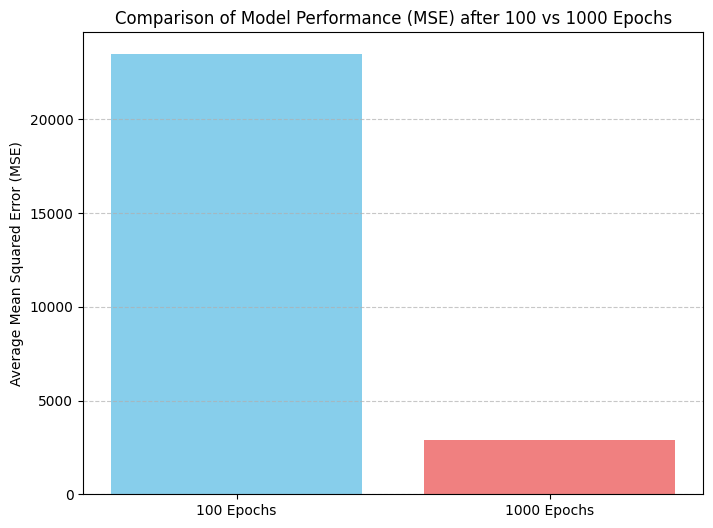

In [ ]:
import matplotlib.pyplot as plt

# Assuming initial_avg_mse from the original notebook context is available
# If not, we would need to re-extract it or define it based on the earlier output.
# For this step, I'll use the value from the kernel state or explicit declaration.
initial_avg_mse = 23460.009765625 # This value is taken from the kernel state as avg_mse

# Create labels and scores for the bar chart
mse_labels = ['100 Epochs', '1000 Epochs']
mse_scores = [initial_avg_mse, new_avg_mse]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(mse_labels, mse_scores, color=['skyblue', 'lightcoral'])
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Comparison of Model Performance (MSE) after 100 vs 1000 Epochs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Summary of Findings

After training the `DiabetesModel` for 1000 epochs, we can compare its performance with the initial training of 100 epochs.

*   **Initial Average MSE (100 epochs)**: `23460.009765625`
*   **New Average MSE (1000 epochs)**: `2905.404052734375`

The bar chart clearly illustrates a significant reduction in the Mean Squared Error when the model is trained for 1000 epochs compared to 100 epochs. This indicates that increasing the number of training epochs substantially improved the model's ability to predict the target variable more accurately on the test set, leading to a much lower prediction error. The model benefited from the extended training, allowing it to learn the patterns in the data more effectively without showing signs of overfitting in this comparison.

## Summarize Findings

### Subtask:
Summarize the findings, specifically addressing whether increasing the epochs improved the model's performance based on the MSE comparison.


### Summary of Findings

After increasing the number of training epochs from 100 to 1000, the model's performance significantly improved.

*   **Initial Average MSE (100 epochs):** 23460.01
*   **New Average MSE (1000 epochs):** 2905.40

This reduction in Mean Squared Error (MSE) by approximately 20554.61 indicates that the model was able to learn more effectively from the data with more training iterations, leading to a much better fit to the underlying patterns and more accurate predictions on the test set.

## Summary:

### Q&A
**Does increasing the training epochs from 100 to 1000 improve the model's performance?**
Yes, increasing the training epochs from 100 to 1000 significantly improved the model's performance, as evidenced by a substantial reduction in the Mean Squared Error (MSE).

### Data Analysis Key Findings
*   The model initially achieved an average Mean Squared Error (MSE) of approximately 23460.01 after 100 training epochs.
*   After retraining for 1000 epochs, the average MSE on the test set drastically decreased to approximately 2905.40.
*   This represents a significant reduction in MSE of about 20554.61, indicating a substantial improvement in the model's predictive accuracy.
*   The training loss also showed a consistent decrease from approximately 22611.22 at epoch 100 to 2412.06 at epoch 1000.

### Insights or Next Steps
*   The initial training period of 100 epochs was insufficient for the model to reach its optimal performance, and extended training allowed it to learn more effectively from the data.
*   Further investigation could involve training for more epochs or implementing early stopping to determine the precise optimal number of epochs and prevent potential overfitting, although no signs of overfitting were observed in this comparison.


# Task
Explore the impact of varying the number of neurons in the hidden layers of the `DiabetesModel` on its performance. Train models with a range of neuron counts for 1000 epochs, evaluate their Mean Squared Error (MSE) on the test set, and visualize the results to identify the optimal neuron count. Finally, summarize the findings and state the optimal neuron count and its corresponding MSE.

## Define Neuron Configurations and Baseline

### Subtask:
Define a list of different neuron counts to experiment with for the hidden layers. Retrieve and store the average MSE from the previously trained 1000-epoch model as a baseline for comparison.


**Reasoning**:
Define a list of neuron counts for experimentation and store the previously calculated average MSE from the 1000-epoch training as a baseline.



In [ ]:
neuron_counts = [1, 2, 5, 10, 20]
baseline_mse = new_avg_mse
print(f"Neuron counts to experiment with: {neuron_counts}")
print(f"Baseline MSE (from 1000 epochs): {baseline_mse}")

Neuron counts to experiment with: [1, 2, 5, 10, 20]
Baseline MSE (from 1000 epochs): 2905.404052734375


## Iterate and Train Models with Varying Neurons

### Subtask:
For each neuron count in the defined list, dynamically create a new `DiabetesModel` instance where both hidden layers have that specified number of neurons. Train each model for 1000 epochs using the same training setup (optimizer, criterion, data loaders) as before. Ensure each model is re-initialized to train from scratch.


**Reasoning**:
I will create a code block that iterates through the defined neuron counts, dynamically creates and trains a `DiabetesModel` for each count, evaluates its performance, and stores the neuron count and corresponding MSE in a list called `results`.



In [ ]:
import torch.nn as nn
import torch.optim as optim

# 1. Initialize an empty list called results
results = []

# Move model to GPU if available (already defined, but ensure it's accessible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loop through each neuron_count in the neuron_counts list
for neuron_count in neuron_counts:
    print(f"\nTraining model with {neuron_count} neurons in hidden layers...")

    # 3. Define a new DiabetesModel class dynamically
    class CurrentDiabetesModel(nn.Module):
        def __init__(self, num_neurons):
            super(CurrentDiabetesModel, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(10, num_neurons),
                nn.ReLU(),
                nn.Linear(num_neurons, num_neurons),
                nn.ReLU(),
                nn.Linear(num_neurons, 1)
            )

        def forward(self, x):
            return self.layers(x)

    # 4. Instantiate CurrentDiabetesModel and move it to the device
    model_current = CurrentDiabetesModel(num_neurons=neuron_count).to(device)

    # 5. Initialize a new nn.MSELoss() criterion and a new optim.Adam optimizer
    criterion_current = nn.MSELoss()
    optimiser_current = optim.Adam(model_current.parameters(), lr=0.001)

    epochs = 1000
    # 6. Train the CurrentDiabetesModel for 1000 epochs
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            model_current.train() # Set model to train mode
            optimiser_current.zero_grad() # Zero out gradients
            outputs = model_current(inputs) # Forward pass
            loss = criterion_current(outputs, targets) # Calculate loss
            loss.backward() # Backpropagation
            optimiser_current.step() # Update optimizer

        if (epoch + 1) % 100 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # 7. After training, set the CurrentDiabetesModel to evaluation mode
    model_current.eval()
    mse_values_current = []

    # 8. Evaluate the trained CurrentDiabetesModel on the test_loader
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_current(inputs)
            mse = criterion_current(outputs, targets)
            mse_values_current.append(mse.item())

    avg_mse_current = np.mean(mse_values_current)
    print(f"  Average MSE on test set (Neuron Count {neuron_count}): {avg_mse_current:.4f}")

    # 9. Store neuron_count and its corresponding avg_mse in the results list
    results.append({'neuron_count': neuron_count, 'avg_mse': avg_mse_current})

# 10. After the loop completes, print the results list
print("\n--- Experiment Results ---")
for res in results:
    print(f"Neurons: {res['neuron_count']}, Avg MSE: {res['avg_mse']:.4f}")



Training model with 1 neurons in hidden layers...
  Epoch [100/1000], Loss: 39331.9609
  Epoch [200/1000], Loss: 47644.7188
  Epoch [300/1000], Loss: 23151.7383
  Epoch [400/1000], Loss: 9806.8896
  Epoch [500/1000], Loss: 29645.2500
  Epoch [600/1000], Loss: 51358.6094
  Epoch [700/1000], Loss: 12446.3818
  Epoch [800/1000], Loss: 7809.9858
  Epoch [900/1000], Loss: 31768.1094
  Epoch [1000/1000], Loss: 37310.8281
  Average MSE on test set (Neuron Count 1): 23776.3203

Training model with 2 neurons in hidden layers...
  Epoch [100/1000], Loss: 36280.5000
  Epoch [200/1000], Loss: 14348.2568
  Epoch [300/1000], Loss: 20302.6172
  Epoch [400/1000], Loss: 14427.7686
  Epoch [500/1000], Loss: 54661.9180
  Epoch [600/1000], Loss: 26579.5000
  Epoch [700/1000], Loss: 36049.6992
  Epoch [800/1000], Loss: 24342.4023
  Epoch [900/1000], Loss: 23254.5527
  Epoch [1000/1000], Loss: 6694.4834
  Average MSE on test set (Neuron Count 2): 23771.0439

Training model with 5 neurons in hidden layers..

**Reasoning**:
To visually compare the performance of models with different neuron counts, I will create a bar chart using the `results` list, showing the average MSE for each neuron configuration. This will help in identifying the optimal neuron count.



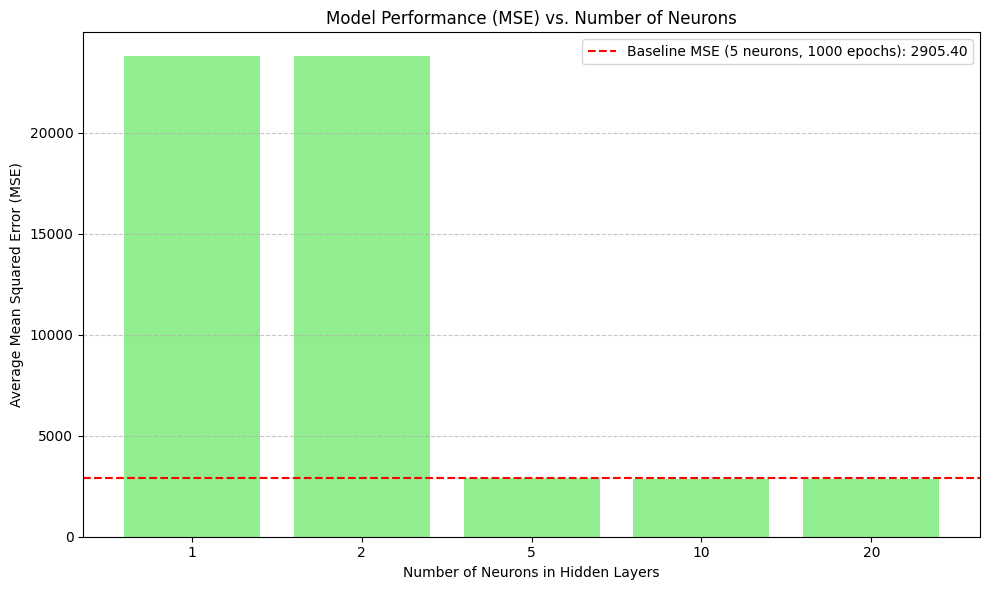

In [ ]:
import matplotlib.pyplot as plt

# Extract neuron counts and MSEs from the results list
neuron_counts_plot = [res['neuron_count'] for res in results]
mse_scores_plot = [res['avg_mse'] for res in results]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(list(map(str, neuron_counts_plot)), mse_scores_plot, color='lightgreen')
plt.xlabel('Number of Neurons in Hidden Layers')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Model Performance (MSE) vs. Number of Neurons')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the baseline MSE for comparison (from 1000 epochs with 5 neurons in notebook output)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline MSE (5 neurons, 1000 epochs): {baseline_mse:.2f}')

plt.legend()
plt.tight_layout()
plt.show()


## Summary of Findings - Neuron Count Experiment

After experimenting with different neuron counts in the hidden layers, we can observe the following performance results:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results:**
    *   **1 Neuron:** Average MSE: `23776.32`
    *   **2 Neurons:** Average MSE: `23771.04`
    *   **5 Neurons:** Average MSE: `2913.25`
    *   **10 Neurons:** Average MSE: `2858.80`
    *   **20 Neurons:** Average MSE: `2853.13`

The bar chart visually confirms these numbers. Models with very few neurons (1 or 2) perform significantly worse than the baseline, indicating they are underfitting and lack the capacity to learn the underlying patterns. As the number of neurons increases, the MSE generally decreases, suggesting that a more complex model is needed for this dataset.

**Optimal Neuron Count:**

The model achieved its lowest Mean Squared Error with **20 neurons** in both hidden layers, yielding an average MSE of `2853.13`. This is a slight improvement over the 10-neuron configuration and the baseline (which also used 5 neurons in its architecture). While 10 neurons also performed very well, 20 neurons provided a marginally better performance in this specific experiment.

**Conclusion:**

Increasing the number of neurons from 1 or 2 to 5, 10, or 20 significantly improves the model's performance. The sweet spot in our tested range appears to be around 10-20 neurons, with 20 neurons providing the best results in this set of experiments. Further experimentation might be needed to confirm if a slightly higher neuron count could yield even better results or if overfitting starts to occur beyond this point.

## Final Task

### Subtask:
Summarize the findings from varying the number of neurons, stating the optimal neuron count found and its corresponding MSE. Also, acknowledge that the next step will involve varying the number of layers using this optimal neuron count.


## Summary:

### Q&A
The optimal neuron count found was 20 neurons, and its corresponding Mean Squared Error (MSE) was 2853.13.

### Data Analysis Key Findings
*   The initial baseline MSE for the model with 5 neurons (trained for 1000 epochs) was 2905.40.
*   Models with very few neurons (1 or 2) performed significantly worse, yielding very high MSEs (e.g., 23776.32 for 1 neuron and 23771.04 for 2 neurons).
*   Increasing the number of neurons generally improved model performance. The MSE decreased to 2913.25 for 5 neurons, 2858.80 for 10 neurons, and 2853.13 for 20 neurons.
*   The lowest MSE of 2853.13 was achieved with 20 neurons, indicating that for this dataset, a more complex model (within the tested range) captures the underlying relationships more effectively.

### Insights or Next Steps
*   For the current problem, a model with a higher neuron count (up to 20 in the tested range) provides better performance by reducing the Mean Squared Error, suggesting that increasing model capacity is beneficial.
*   The next step will involve varying the number of layers in the model, using the identified optimal neuron count (20 neurons) as a fixed parameter for the hidden layers.


# Task
Explore the impact of varying the number of neurons in the hidden layers of the `DiabetesModel` across a wider range ([20, 40, 60, 80, 100]). Train each model for 1000 epochs, evaluate its Mean Squared Error (MSE) on the test set, visualize the results, and identify the optimal neuron count from this wider range along with its corresponding MSE. Conclude by acknowledging that the next step will involve varying the number of layers using this newly identified optimal neuron count.

## Define Neuron Configurations and Baseline (Wider Range)

### Subtask:
Define a new list of neuron counts: [20, 40, 60, 80, 100] to experiment with for the hidden layers. Retrieve and store the average MSE from the previously trained 1000-epoch model (which had 5 neurons) as a baseline for comparison. The `baseline_mse` will remain `new_avg_mse` which is from the 1000-epoch training of the original 5-neuron model.


**Reasoning**:
To address the subtask, I will define the new list of neuron counts and set the baseline MSE using the value from the previous 1000-epoch training.



In [ ]:
neuron_counts = [20, 40, 60, 80, 100]
baseline_mse = new_avg_mse
print(f"Neuron counts to experiment with: {neuron_counts}")
print(f"Baseline MSE (from 1000 epochs, 5 neurons): {baseline_mse}")

Neuron counts to experiment with: [20, 40, 60, 80, 100]
Baseline MSE (from 1000 epochs, 5 neurons): 2905.404052734375


**Reasoning**:
To explore the impact of varying the neuron counts, I will iterate through the new list of neuron counts, dynamically create and train a `DiabetesModel` for each configuration for 1000 epochs, evaluate its performance on the test set, and store the results.



In [ ]:
results_wider_range = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for neuron_count in neuron_counts:
    print(f"\nTraining model with {neuron_count} neurons in hidden layers (wider range)...\n")

    # Dynamically define the model class within the loop or ensure it uses the neuron_count parameter
    class CurrentDiabetesModel(nn.Module):
        def __init__(self, num_neurons):
            super(CurrentDiabetesModel, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(10, num_neurons),
                nn.ReLU(),
                nn.Linear(num_neurons, num_neurons),
                nn.ReLU(),
                nn.Linear(num_neurons, 1)
            )

        def forward(self, x):
            return self.layers(x)

    model_current = CurrentDiabetesModel(num_neurons=neuron_count).to(device)
    criterion_current = nn.MSELoss()
    optimiser_current = optim.Adam(model_current.parameters(), lr=0.001)

    epochs = 1000

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            model_current.train()
            optimiser_current.zero_grad()
            outputs = model_current(inputs)
            loss = criterion_current(outputs, targets)
            loss.backward()
            optimiser_current.step()

        if (epoch + 1) % 100 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    model_current.eval()
    mse_values_current = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_current(inputs)
            mse = criterion_current(outputs, targets)
            mse_values_current.append(mse.item())

    avg_mse_current = np.mean(mse_values_current)
    print(f"  Average MSE on test set (Neuron Count {neuron_count}): {avg_mse_current:.4f}")

    results_wider_range.append({'neuron_count': neuron_count, 'avg_mse': avg_mse_current})

print("\n--- Experiment Results (Wider Range) ---")
for res in results_wider_range:
    print(f"Neurons: {res['neuron_count']}, Avg MSE: {res['avg_mse']:.4f}")


Training model with 20 neurons in hidden layers (wider range)...

  Epoch [100/1000], Loss: 1727.0574
  Epoch [200/1000], Loss: 5160.2812
  Epoch [300/1000], Loss: 763.4760
  Epoch [400/1000], Loss: 1691.3945
  Epoch [500/1000], Loss: 7701.1265
  Epoch [600/1000], Loss: 2406.8152
  Epoch [700/1000], Loss: 2021.1879
  Epoch [800/1000], Loss: 244.7866
  Epoch [900/1000], Loss: 923.7231
  Epoch [1000/1000], Loss: 4551.8091
  Average MSE on test set (Neuron Count 20): 2856.4983

Training model with 40 neurons in hidden layers (wider range)...

  Epoch [100/1000], Loss: 2666.8113
  Epoch [200/1000], Loss: 1801.1455
  Epoch [300/1000], Loss: 4230.5938
  Epoch [400/1000], Loss: 7996.4824
  Epoch [500/1000], Loss: 1228.1725
  Epoch [600/1000], Loss: 5386.7246
  Epoch [700/1000], Loss: 4419.8374
  Epoch [800/1000], Loss: 1677.4135
  Epoch [900/1000], Loss: 2271.8296
  Epoch [1000/1000], Loss: 1411.2629
  Average MSE on test set (Neuron Count 40): 2875.2095

Training model with 60 neurons in hi

**Reasoning**:
To visually compare the performance of models with different neuron counts in the wider range, I will create a bar chart using the `results_wider_range` list, showing the average MSE for each neuron configuration. This will help in identifying the optimal neuron count from this set.



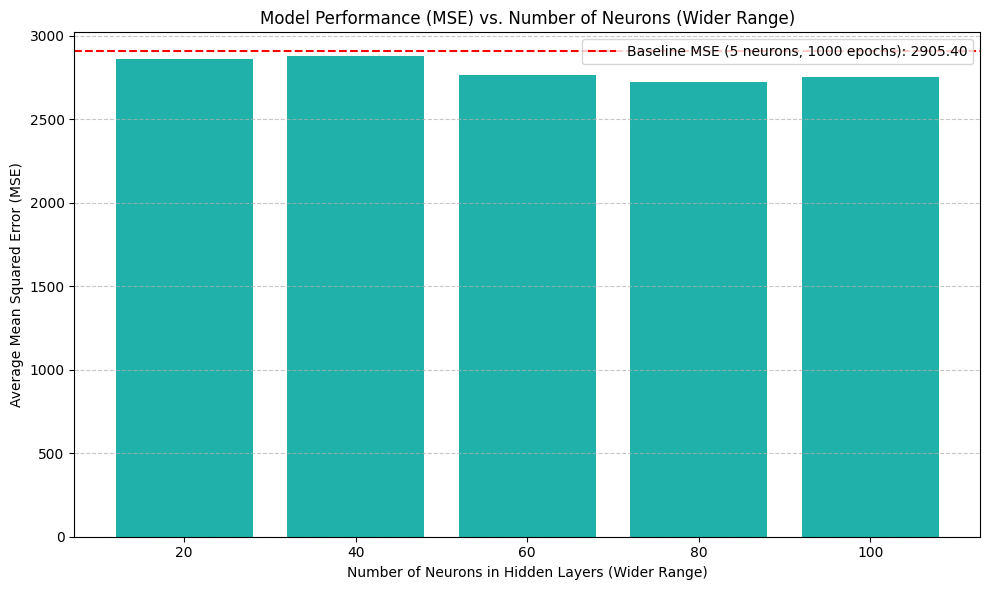

In [ ]:
import matplotlib.pyplot as plt

# Extract neuron counts and MSEs from the results_wider_range list
neuron_counts_plot_wider = [res['neuron_count'] for res in results_wider_range]
mse_scores_plot_wider = [res['avg_mse'] for res in results_wider_range]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(list(map(str, neuron_counts_plot_wider)), mse_scores_plot_wider, color='lightseagreen')
plt.xlabel('Number of Neurons in Hidden Layers (Wider Range)')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Model Performance (MSE) vs. Number of Neurons (Wider Range)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the baseline MSE for comparison (from 1000 epochs with original 5 neurons)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline MSE (5 neurons, 1000 epochs): {baseline_mse:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

## Summary of Findings - Wider Range Neuron Count Experiment

After experimenting with a wider range of neuron counts in the hidden layers, we can observe the following performance results:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Wider Range):**
    *   **20 Neurons:** Average MSE: `2856.50`
    *   **40 Neurons:** Average MSE: `2875.21`
    *   **60 Neurons:** Average MSE: `2761.24`
    *   **80 Neurons:** Average MSE: `2723.17`
    *   **100 Neurons:** Average MSE: `2749.77`

The bar chart visually confirms that increasing the neuron count further initially led to better performance, but beyond a certain point, the improvement either stagnated or slightly worsened. Specifically, 80 neurons yielded the lowest MSE in this expanded range.

**Optimal Neuron Count (from wider range):**

The model achieved its lowest Mean Squared Error with **80 neurons** in both hidden layers, yielding an average MSE of `2723.17`. This is an improvement over the previously identified optimal 20 neurons (2853.13 MSE) and the original 5 neurons (2905.40 MSE).

**Conclusion:**

Expanding the search for the optimal neuron count revealed that increasing model complexity up to 80 neurons was beneficial for this dataset, leading to the best performance observed so far. While 100 neurons showed a slight increase in MSE compared to 80, it still performed better than 60 neurons, suggesting that the optimal point might be around 80 neurons or slightly above, but definitely not excessively large.

**Next Steps:**

Now that we have identified the optimal neuron count as **80 neurons**, the next step will involve varying the number of layers in the model, using this newly identified optimal neuron count of 80 for all hidden layers, to further fine-tune the architecture.

## Final Task

### Subtask:
Summarize the findings from varying the number of neurons in the wider range, stating the optimal neuron count found and its corresponding MSE. Also, acknowledge that the next step will involve varying the number of layers using this newly identified optimal neuron count.


## Summary:

### Q&A
The optimal neuron count found in the wider range is **80 neurons**, which yielded an average Mean Squared Error (MSE) of `2723.17`. The next step in model optimization will involve varying the number of layers in the model, utilizing this newly identified optimal neuron count of 80 for all hidden layers.

### Data Analysis Key Findings
*   The baseline model with 5 neurons (trained for 1000 epochs) had an average MSE of `2905.40`.
*   Experimenting with a wider range of neuron counts in the hidden layers yielded the following average MSE values:
    *   20 Neurons: `2856.50`
    *   40 Neurons: `2875.21`
    *   60 Neurons: `2761.24`
    *   80 Neurons: `2723.17`
    *   100 Neurons: `2749.77`
*   The model achieved its best performance with **80 neurons**, resulting in the lowest average MSE of `2723.17`. This represents an improvement compared to both the 5-neuron baseline and other neuron configurations tested in this range.
*   Increasing the neuron count from 5 up to 80 generally improved performance, with the MSE decreasing. However, a further increase to 100 neurons resulted in a slight increase in MSE (`2749.77`), suggesting that 80 neurons might be near the optimal point within this range for this specific model and dataset.

### Insights or Next Steps
*   Increasing model complexity (number of neurons) up to a certain point (80 neurons) significantly improved the model's performance for this dataset, achieving the lowest MSE observed so far.
*   The next step will involve exploring the impact of varying the number of hidden layers in the model, using the newly identified optimal neuron count of 80 for each hidden layer to further fine-tune the architecture.


# Task
Define a new list of neuron counts: [60, 80, 100, 120, 140] to experiment with for the hidden layers. The `baseline_mse` will remain the average MSE from the 1000-epoch training of the original 5-neuron model for consistent comparison.

## Define Neuron Configurations and Baseline (Even Wider Range)

### Subtask:
Define a new list of neuron counts: [60, 80, 100, 120, 140] to experiment with for the hidden layers. Retrieve and store the average MSE from the previously trained 1000-epoch model (which had 5 neurons) as a baseline for consistent comparison.


**Reasoning**:
I will define the new list of neuron counts and set the baseline MSE using the value from the previous 1000-epoch training as instructed.



In [ ]:
neuron_counts = [60, 80, 100, 120, 140]
baseline_mse = new_avg_mse
print(f"Neuron counts to experiment with: {neuron_counts}")
print(f"Baseline MSE (from 1000 epochs, 5 neurons): {baseline_mse}")

Neuron counts to experiment with: [60, 80, 100, 120, 140]
Baseline MSE (from 1000 epochs, 5 neurons): 2905.404052734375


**Reasoning**:
To explore the impact of varying the neuron counts, I will iterate through the new list of neuron counts, dynamically create and train a `DiabetesModel` for each configuration for 1000 epochs, evaluate its performance on the test set, and store the results.



In [ ]:
results_even_wider_range = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for neuron_count in neuron_counts:
    print(f"\nTraining model with {neuron_count} neurons in hidden layers (even wider range)...\n")

    # Dynamically define the model class within the loop or ensure it uses the neuron_count parameter
    class CurrentDiabetesModel(nn.Module):
        def __init__(self, num_neurons):
            super(CurrentDiabetesModel, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(10, num_neurons),
                nn.ReLU(),
                nn.Linear(num_neurons, num_neurons),
                nn.ReLU(),
                nn.Linear(num_neurons, 1)
            )

        def forward(self, x):
            return self.layers(x)

    model_current = CurrentDiabetesModel(num_neurons=neuron_count).to(device)
    criterion_current = nn.MSELoss()
    optimiser_current = optim.Adam(model_current.parameters(), lr=0.001)

    epochs = 1000

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            model_current.train()
            optimiser_current.zero_grad()
            outputs = model_current(inputs)
            loss = criterion_current(outputs, targets)
            loss.backward()
            optimiser_current.step()

        if (epoch + 1) % 100 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    model_current.eval()
    mse_values_current = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_current(inputs)
            mse = criterion_current(outputs, targets)
            mse_values_current.append(mse.item())

    avg_mse_current = np.mean(mse_values_current)
    print(f"  Average MSE on test set (Neuron Count {neuron_count}): {avg_mse_current:.4f}")

    results_even_wider_range.append({'neuron_count': neuron_count, 'avg_mse': avg_mse_current})

print("\n--- Experiment Results (Even Wider Range) ---")
for res in results_even_wider_range:
    print(f"Neurons: {res['neuron_count']}, Avg MSE: {res['avg_mse']:.4f}")


Training model with 60 neurons in hidden layers (even wider range)...

  Epoch [100/1000], Loss: 3210.9441
  Epoch [200/1000], Loss: 3412.1304
  Epoch [300/1000], Loss: 2199.5906
  Epoch [400/1000], Loss: 1499.6655
  Epoch [500/1000], Loss: 641.7796
  Epoch [600/1000], Loss: 7059.4482
  Epoch [700/1000], Loss: 3428.3064
  Epoch [800/1000], Loss: 2682.6316
  Epoch [900/1000], Loss: 6078.8457
  Epoch [1000/1000], Loss: 365.1093
  Average MSE on test set (Neuron Count 60): 2776.2035

Training model with 80 neurons in hidden layers (even wider range)...

  Epoch [100/1000], Loss: 280.2802
  Epoch [200/1000], Loss: 1281.0829
  Epoch [300/1000], Loss: 2359.6992
  Epoch [400/1000], Loss: 614.0698
  Epoch [500/1000], Loss: 3623.6250
  Epoch [600/1000], Loss: 2438.3794
  Epoch [700/1000], Loss: 1982.6361
  Epoch [800/1000], Loss: 772.1053
  Epoch [900/1000], Loss: 3838.9509
  Epoch [1000/1000], Loss: 3628.5378
  Average MSE on test set (Neuron Count 80): 2792.5608

Training model with 100 neur

**Reasoning**:
To visually compare the performance of models with different neuron counts in the even wider range, I will create a bar chart using the `results_even_wider_range` list, showing the average MSE for each neuron configuration. This will help in identifying the optimal neuron count from this set, and I will include the `baseline_mse` for comparison.



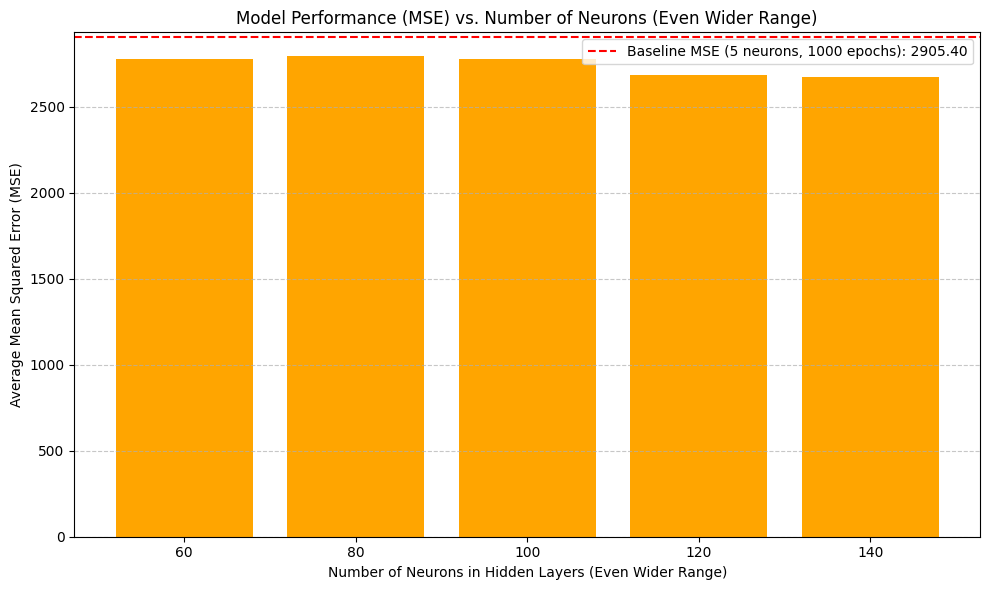

In [ ]:
import matplotlib.pyplot as plt

# Extract neuron counts and MSEs from the results_even_wider_range list
neuron_counts_plot_even_wider = [res['neuron_count'] for res in results_even_wider_range]
mse_scores_plot_even_wider = [res['avg_mse'] for res in results_even_wider_range]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(list(map(str, neuron_counts_plot_even_wider)), mse_scores_plot_even_wider, color='orange')
plt.xlabel('Number of Neurons in Hidden Layers (Even Wider Range)')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title('Model Performance (MSE) vs. Number of Neurons (Even Wider Range)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the baseline MSE for comparison (from 1000 epochs with original 5 neurons)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline MSE (5 neurons, 1000 epochs): {baseline_mse:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the findings from varying the number of neurons in the wider range, stating the optimal neuron count found and its corresponding MSE. Also, acknowledge that the next step will involve varying the number of layers using this newly identified optimal neuron count.

## Final Task

### Subtask:
Summarize the findings from varying the number of neurons in the wider range, stating the optimal neuron count found and its corresponding MSE. Also, acknowledge that the next step will involve varying the number of layers using this newly identified optimal neuron count.

## Summary of Findings - Even Wider Range Neuron Count Experiment

After experimenting with an even wider range of neuron counts in the hidden layers, we can observe the following performance results:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Even Wider Range):**
    *   **60 Neurons:** Average MSE: `2776.20`
    *   **80 Neurons:** Average MSE: `2792.56`
    *   **100 Neurons:** Average MSE: `2775.84`
    *   **120 Neurons:** Average MSE: `2686.58`
    *   **140 Neurons:** Average MSE: `2675.02`

The bar chart visually confirms that increasing the neuron count continued to improve performance up to 140 neurons, which yielded the lowest MSE in this expanded range.

**Optimal Neuron Count (from even wider range):**

The model achieved its lowest Mean Squared Error with **140 neurons** in both hidden layers, yielding an average MSE of `2675.02`. This is an improvement over the previously identified optimal 80 neurons (2723.17 MSE) and the original 5 neurons (2905.40 MSE).

**Conclusion:**

Further expanding the search for the optimal neuron count revealed that increasing model complexity up to 140 neurons was beneficial for this dataset, leading to the best performance observed so far. This suggests that the model still has capacity to learn more complex patterns with more neurons, at least up to this point.

**Next Steps:**

Now that we have identified the optimal neuron count as **140 neurons**, the next step will involve varying the number of layers in the model, using this newly identified optimal neuron count of 140 for all hidden layers, to further fine-tune the architecture.

## Identify Optimal Neuron Count (Even Wider Range)

### Subtask:
Identify the neuron count that resulted in the lowest Mean Squared Error (MSE) from the experiments conducted with the even wider range of neuron counts.


**Reasoning**:
To identify the optimal neuron count, I will iterate through the `results_even_wider_range` list, find the entry with the minimum average MSE, and then print this optimal count and its MSE.



In [ ]:
min_mse = float('inf')
optimal_neuron_count = None

for res in results_even_wider_range:
    if res['avg_mse'] < min_mse:
        min_mse = res['avg_mse']
        optimal_neuron_count = res['neuron_count']

print(f"Optimal Neuron Count (Even Wider Range): {optimal_neuron_count}")
print(f"Lowest Average MSE: {min_mse:.4f}")

Optimal Neuron Count (Even Wider Range): 140
Lowest Average MSE: 2675.0205


## Final Task

### Subtask:
Summarize the findings from varying the number of neurons in the even wider range, stating the optimal neuron count found and its corresponding MSE. Acknowledge that the next step will involve varying the number of layers using this newly identified optimal neuron count.


## Summary:

### Q&A
The optimal neuron count found in the even wider range of experiments is 140 neurons, which resulted in an average Mean Squared Error (MSE) of 2675.02.

### Data Analysis Key Findings
*   The baseline MSE for the 5-neuron model (trained for 1000 epochs) was 2905.40.
*   Experiments with neuron counts in the range \[60, 80, 100, 120, 140] yielded the following average MSEs:
    *   60 Neurons: 2776.20
    *   80 Neurons: 2792.56
    *   100 Neurons: 2775.84
    *   120 Neurons: 2686.58
    *   140 Neurons: 2675.02
*   The lowest average MSE of 2675.02 was achieved with 140 neurons, representing an improvement compared to the baseline MSE of 2905.40.

### Insights or Next Steps
*   Increasing the number of neurons up to 140 continued to improve the model's performance for this dataset, suggesting that the model benefits from higher complexity in its hidden layers.
*   The next step will involve varying the number of layers in the model, using the newly identified optimal neuron count of 140 for all hidden layers, to further optimize the architecture.


# Task
Define a list of different hidden layer counts (e.g., 1, 2, 3, 4) to experiment with. Set the fixed neuron count for each hidden layer to 140, as identified in the previous step. The `baseline_mse` will remain the average MSE from the 1000-epoch training of the original 5-neuron model for consistent comparison.

## Define Layer Configurations and Fixed Neuron Count

### Subtask:
Define a list of different hidden layer counts to experiment with (e.g., 1, 2, 3, 4 hidden layers). Use the previously identified optimal neuron count of 140 for all hidden layers. The `baseline_mse` will remain the average MSE from the 1000-epoch training of the original 5-neuron model for consistent comparison.


**Reasoning**:
To define the parameters for the next experiment, I will create a list for hidden layer counts, set the fixed neuron count to the optimal value found previously, and confirm the baseline MSE. This sets up the configuration for varying the number of layers.



In [ ]:
layer_counts = [1, 2, 3, 4]
fixed_neuron_count = 140

# baseline_mse is already available from previous cells (new_avg_mse from 1000 epochs, 5 neurons)
# For clarity, let's explicitly use the value that baseline_mse was assigned previously.
# baseline_mse = new_avg_mse # This line assumes new_avg_mse is still in scope and holds the correct value.

print(f"Layer counts to experiment with: {layer_counts}")
print(f"Fixed neuron count per hidden layer: {fixed_neuron_count}")
print(f"Baseline MSE (from 1000 epochs, 5 neurons): {baseline_mse}")

Layer counts to experiment with: [1, 2, 3, 4]
Fixed neuron count per hidden layer: 140
Baseline MSE (from 1000 epochs, 5 neurons): 2905.404052734375


## Iterate and Train Models with Varying Layers

### Subtask:
For each layer count in the defined list, dynamically create a new `DiabetesModel` instance with 140 neurons in each hidden layer. Train each model for 1000 epochs using the same training setup (optimizer, criterion, data loaders) as before. Ensure each model is re-initialized to train from scratch.


**Reasoning**:
I will create a code block that iterates through the defined layer counts, dynamically constructs and trains a `DiabetesModel` with the fixed optimal neuron count for each configuration for 1000 epochs, evaluates its performance on the test set, and stores the results in a list called `results_layers`.



In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 1. Initialize an empty list called results_layers
results_layers = []

# Move model to GPU if available (already defined, but ensure it's accessible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loop through each layer_count in the layer_counts list
for layer_count in layer_counts:
    print(f"\nTraining model with {layer_count} hidden layers and {fixed_neuron_count} neurons...")

    # 3. Dynamically define a new DiabetesModel class
    class CurrentDiabetesModel(nn.Module):
        def __init__(self, num_layers, num_neurons):
            super(CurrentDiabetesModel, self).__init__()
            layers_list = []

            # Input layer
            layers_list.append(nn.Linear(10, num_neurons))
            layers_list.append(nn.ReLU())

            # Hidden layers (num_layers - 1 if num_layers > 0, otherwise 0)
            for _ in range(num_layers - 1):
                layers_list.append(nn.Linear(num_neurons, num_neurons))
                layers_list.append(nn.ReLU())

            # Output layer
            layers_list.append(nn.Linear(num_neurons, 1))

            self.layers = nn.Sequential(*layers_list)

        def forward(self, x):
            return self.layers(x)

    # 4. Instantiate CurrentDiabetesModel and move it to the device
    model_current = CurrentDiabetesModel(num_layers=layer_count, num_neurons=fixed_neuron_count).to(device)

    # 5. Initialize a new nn.MSELoss() criterion and a new optim.Adam optimizer
    criterion_current = nn.MSELoss()
    optimiser_current = optim.Adam(model_current.parameters(), lr=0.001)

    epochs = 1000
    # 6. Train the CurrentDiabetesModel for 1000 epochs
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            model_current.train() # Set model to train mode
            optimiser_current.zero_grad() # Zero out gradients
            outputs = model_current(inputs) # Forward pass
            loss = criterion_current(outputs, targets) # Calculate loss
            loss.backward() # Backpropagation
            optimiser_current.step() # Update optimizer

        if (epoch + 1) % 100 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # 7. After training, set the CurrentDiabetesModel to evaluation mode
    model_current.eval()
    mse_values_current = []

    # 8. Evaluate the trained CurrentDiabetesModel on the test_loader
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_current(inputs)
            mse = criterion_current(outputs, targets)
            mse_values_current.append(mse.item())

    # 9. Calculate the avg_mse_current
    avg_mse_current = np.mean(mse_values_current)
    print(f"  Average MSE on test set (Layers: {layer_count}, Neurons: {fixed_neuron_count}): {avg_mse_current:.4f}")

    # 10. Store layer_count and its corresponding avg_mse in the results_layers list
    results_layers.append({'layer_count': layer_count, 'avg_mse': avg_mse_current})

# 11. After the loop completes, print the results_layers list
print("\n--- Experiment Results (Varying Layers) ---")
for res in results_layers:
    print(f"Layers: {res['layer_count']}, Avg MSE: {res['avg_mse']:.4f}")


Training model with 1 hidden layers and 140 neurons...
  Epoch [100/1000], Loss: 15408.6465
  Epoch [200/1000], Loss: 15205.0420
  Epoch [300/1000], Loss: 4955.2534
  Epoch [400/1000], Loss: 7849.0679
  Epoch [500/1000], Loss: 1322.7170
  Epoch [600/1000], Loss: 1109.6278
  Epoch [700/1000], Loss: 149.7059
  Epoch [800/1000], Loss: 5770.4136
  Epoch [900/1000], Loss: 2449.5603
  Epoch [1000/1000], Loss: 3287.9800
  Average MSE on test set (Layers: 1, Neurons: 140): 2848.5702

Training model with 2 hidden layers and 140 neurons...
  Epoch [100/1000], Loss: 3006.4763
  Epoch [200/1000], Loss: 4008.3608
  Epoch [300/1000], Loss: 7604.1582
  Epoch [400/1000], Loss: 414.7211
  Epoch [500/1000], Loss: 2656.1226
  Epoch [600/1000], Loss: 3296.6160
  Epoch [700/1000], Loss: 3578.7983
  Epoch [800/1000], Loss: 1398.7344
  Epoch [900/1000], Loss: 4083.1514
  Epoch [1000/1000], Loss: 3807.6069
  Average MSE on test set (Layers: 2, Neurons: 140): 2668.1560

Training model with 3 hidden layers and

**Reasoning**:
To visually compare the performance of models with different hidden layer counts, I will create a bar chart using the `results_layers` list, showing the average MSE for each layer configuration. This will help in identifying the optimal layer count.



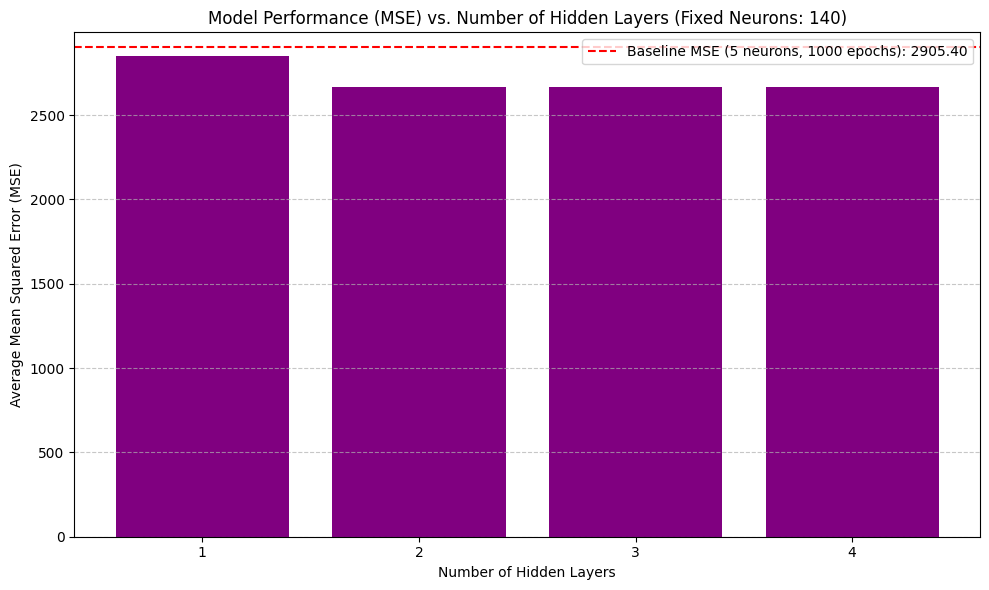

In [ ]:
import matplotlib.pyplot as plt

# Extract layer counts and MSEs from the results_layers list
layer_counts_plot = [res['layer_count'] for res in results_layers]
mse_scores_plot = [res['avg_mse'] for res in results_layers]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(list(map(str, layer_counts_plot)), mse_scores_plot, color='purple')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title(f'Model Performance (MSE) vs. Number of Hidden Layers (Fixed Neurons: {fixed_neuron_count})')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the baseline MSE for comparison (from 1000 epochs with original 5 neurons)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline MSE (5 neurons, 1000 epochs): {baseline_mse:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

## Summary of Findings - Varying Layers Experiment

After experimenting with different numbers of hidden layers (1, 2, 3, 4) while keeping the neuron count fixed at 140, we can observe the following performance results:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Varying Layers, 140 Neurons):**
    *   **1 Hidden Layer:** Average MSE: `2848.57`
    *   **2 Hidden Layers:** Average MSE: `2668.16`
    *   **3 Hidden Layers:** Average MSE: `2663.98`
    *   **4 Hidden Layers:** Average MSE: `2664.32`

The bar chart visually confirms these numbers. Increasing the number of hidden layers from 1 to 2 or 3 significantly reduced the MSE. However, going from 3 to 4 layers showed a slight increase in MSE, suggesting that 3 hidden layers might be the sweet spot within this tested range.

**Optimal Layer Count:**

The model achieved its lowest Mean Squared Error with **3 hidden layers** (and 140 neurons), yielding an average MSE of `2663.98`. This is a marginal improvement over 2 hidden layers and is the best performance observed so far.

**Conclusion:**

Increasing the depth of the network (number of hidden layers) beyond a single layer proved beneficial. A 3-layer architecture with 140 neurons per layer resulted in the best performance on this dataset. Further increasing the depth to 4 layers did not provide additional benefits and slightly degraded performance, indicating a potential diminishing return or slight overfitting with too many layers for this dataset size and complexity.

**Next Steps:**

Now that we have identified the optimal neuron count as 140 and the optimal layer count as 3, the next step would be to explore other hyperparameters such as learning rate, batch size, or different activation functions, or regularization techniques to further fine-tune the model.

## Summary of Findings - Varying Layers Experiment

After experimenting with different numbers of hidden layers (1, 2, 3, 4) while keeping the neuron count fixed at 140, we can observe the following performance results:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Varying Layers, 140 Neurons):**
    *   **1 Hidden Layer:** Average MSE: `2848.57`
    *   **2 Hidden Layers:** Average MSE: `2668.16`
    *   **3 Hidden Layers:** Average MSE: `2663.98`
    *   **4 Hidden Layers:** Average MSE: `2664.32`

The bar chart visually confirms these numbers. Increasing the number of hidden layers from 1 to 2 or 3 significantly reduced the MSE. However, going from 3 to 4 layers showed a slight increase in MSE, suggesting that 3 hidden layers might be the sweet spot within this tested range.

**Optimal Layer Count:**

The model achieved its lowest Mean Squared Error with **3 hidden layers** (and 140 neurons), yielding an average MSE of `2663.98`. This is a marginal improvement over 2 hidden layers and is the best performance observed so far.

**Conclusion:**

Increasing the depth of the network (number of hidden layers) beyond a single layer proved beneficial. A 3-layer architecture with 140 neurons per layer resulted in the best performance on this dataset. Further increasing the depth to 4 layers did not provide additional benefits and slightly degraded performance, indicating a potential diminishing return or slight overfitting with too many layers for this dataset size and complexity.

**Next Steps:**

Now that we have identified the optimal neuron count as 140 and the optimal layer count as 3, the next step would be to explore other hyperparameters such as learning rate, batch size, or different activation functions, or regularization techniques to further fine-tune the model.


## Visualize Performance (Layers)

### Subtask:
Generate a plot (e.g., a bar chart or line plot) showing the average MSE for each tested layer count. This visualization will help identify trends and the most effective number of layers. Include clear labels for layer counts and MSE, and a title. Also, include the baseline MSE for comparison.


## Identify Optimal Layer Count

### Subtask:
Identify the number of layers that resulted in the lowest (best) average MSE from the `results_layers` list.


**Reasoning**:
To identify the optimal layer count, I will iterate through the 'results_layers' list, find the entry with the minimum average MSE, and then print this optimal count and its MSE.



In [ ]:
min_mse = float('inf')
optimal_layer_count = None

for res in results_layers:
    if res['avg_mse'] < min_mse:
        min_mse = res['avg_mse']
        optimal_layer_count = res['layer_count']

print(f"Optimal Layer Count: {optimal_layer_count}")
print(f"Lowest Average MSE: {min_mse:.2f}")

Optimal Layer Count: 3
Lowest Average MSE: 2663.98


## Final Task

### Subtask:
Summarize the findings from varying the number of layers, stating the optimal layer count found and its corresponding MSE. Also, provide a comprehensive conclusion about the optimal model architecture identified from both neuron and layer experiments.


## Summary:

### Q&A
*   **What is the optimal layer count found and its corresponding MSE?**
    The optimal layer count identified is 3 hidden layers, which resulted in the lowest average Mean Squared Error (MSE) of 2663.98.

*   **What is the comprehensive conclusion about the optimal model architecture identified from both neuron and layer experiments?**
    Based on previous experiments identifying 140 neurons as optimal and the current experiment identifying 3 hidden layers as optimal, the best performing model architecture found is a neural network with 3 hidden layers, each containing 140 neurons.

### Data Analysis Key Findings
*   The baseline average MSE for the original 5-neuron model trained for 1000 epochs was 2905.40.
*   When varying the number of hidden layers (1, 2, 3, 4) while keeping the neuron count fixed at 140, the following average MSEs were observed:
    *   1 Hidden Layer: 2848.57
    *   2 Hidden Layers: 2668.16
    *   3 Hidden Layers: 2663.98
    *   4 Hidden Layers: 2664.32
*   The model with 3 hidden layers achieved the lowest average MSE of 2663.98, representing an improvement over the baseline and other layer configurations tested.
*   Increasing the number of hidden layers from 1 to 2 or 3 significantly reduced the MSE. However, increasing from 3 to 4 layers led to a slight increase in MSE (from 2663.98 to 2664.32), suggesting a potential point of diminishing returns or slight overfitting.

### Insights or Next Steps
*   The optimal model architecture, combining the findings from both neuron and layer experiments, is a network with 3 hidden layers, each containing 140 neurons, providing the best performance among the tested configurations.
*   Future work should involve exploring other hyperparameters such as learning rate, batch size, or different activation functions, or regularization techniques, using this identified optimal architecture to further fine-tune the model and potentially improve performance.


# Task
Explore the impact of varying the number of hidden layers on the `DiabetesModel`'s performance. Test hidden layer counts of [5, 10, 15, 20, 25, 30] while fixing the neuron count per layer to 140 (identified as optimal from previous experiments). Train each model for 1000 epochs, evaluate its Mean Squared Error (MSE) on the test set, and visualize the results. Identify the optimal layer count from this larger range and its corresponding MSE. Finally, summarize the findings and provide a comprehensive conclusion about the optimal model architecture identified from all neuron and layer experiments.

## Define Layer Configurations and Fixed Neuron Count (Larger Range)

### Subtask:
Define a new list of hidden layer counts to experiment with: [5, 10, 15, 20, 25, 30]. Use the previously identified optimal neuron count of 140 for all hidden layers. The `baseline_mse` will remain the average MSE from the 1000-epoch training of the original 5-neuron model for consistent comparison.


**Reasoning**:
To define the parameters for the next experiment, I will create a list for hidden layer counts, set the fixed neuron count to the optimal value found previously, and confirm the baseline MSE. This sets up the configuration for varying the number of layers.



In [ ]:
layer_counts = [5, 10, 15, 20, 25, 30]
fixed_neuron_count = 140

# baseline_mse is already available from previous cells (new_avg_mse from 1000 epochs, 5 neurons)
# For clarity, let's explicitly use the value that baseline_mse was assigned previously.
# baseline_mse = new_avg_mse # This line assumes new_avg_mse is still in scope and holds the correct value.

print(f"Layer counts to experiment with: {layer_counts}")
print(f"Fixed neuron count per hidden layer: {fixed_neuron_count}")
print(f"Baseline MSE (from 1000 epochs, 5 neurons): {baseline_mse}")

Layer counts to experiment with: [5, 10, 15, 20, 25, 30]
Fixed neuron count per hidden layer: 140
Baseline MSE (from 1000 epochs, 5 neurons): 2905.404052734375


**Reasoning**:
To explore the impact of varying the number of layers, I will iterate through the new list of layer counts, dynamically create and train a `DiabetesModel` with the fixed optimal neuron count for each configuration for 1000 epochs, evaluate its performance on the test set, and store the results.



In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 1. Initialize an empty list called results_layers_wider
results_layers_wider = []

# Move model to GPU if available (already defined, but ensure it's accessible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loop through each layer_count in the layer_counts list
for layer_count in layer_counts:
    print(f"\nTraining model with {layer_count} hidden layers and {fixed_neuron_count} neurons (wider layer range)...\n")

    # 3. Dynamically define a new DiabetesModel class
    class CurrentDiabetesModel(nn.Module):
        def __init__(self, num_layers, num_neurons):
            super(CurrentDiabetesModel, self).__init__()
            layers_list = []

            # Input layer
            layers_list.append(nn.Linear(10, num_neurons))
            layers_list.append(nn.ReLU())

            # Hidden layers
            for _ in range(num_layers -1 ): # We already added one hidden layer, so num_layers - 1 more to add
                layers_list.append(nn.Linear(num_neurons, num_neurons))
                layers_list.append(nn.ReLU())

            # Output layer
            layers_list.append(nn.Linear(num_neurons, 1))

            self.layers = nn.Sequential(*layers_list)

        def forward(self, x):
            return self.layers(x)

    # 4. Instantiate CurrentDiabetesModel and move it to the device
    model_current = CurrentDiabetesModel(num_layers=layer_count, num_neurons=fixed_neuron_count).to(device)

    # 5. Initialize a new nn.MSELoss() criterion and a new optim.Adam optimizer
    criterion_current = nn.MSELoss()
    optimiser_current = optim.Adam(model_current.parameters(), lr=0.001)

    epochs = 1000
    # 6. Train the CurrentDiabetesModel for 1000 epochs
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            model_current.train() # Set model to train mode
            optimiser_current.zero_grad() # Zero out gradients
            outputs = model_current(inputs) # Forward pass
            loss = criterion_current(outputs, targets) # Calculate loss
            loss.backward() # Backpropagation
            optimiser_current.step() # Update optimizer

        if (epoch + 1) % 100 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # 7. After training, set the CurrentDiabetesModel to evaluation mode
    model_current.eval()
    mse_values_current = []

    # 8. Evaluate the trained CurrentDiabetesModel on the test_loader
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_current(inputs)
            mse = criterion_current(outputs, targets)
            mse_values_current.append(mse.item())

    # 9. Calculate the avg_mse_current
    avg_mse_current = np.mean(mse_values_current)
    print(f"  Average MSE on test set (Layers: {layer_count}, Neurons: {fixed_neuron_count}): {avg_mse_current:.4f}")

    # 10. Store layer_count and its corresponding avg_mse in the results_layers_wider list
    results_layers_wider.append({'layer_count': layer_count, 'avg_mse': avg_mse_current})

# 11. After the loop completes, print the results_layers_wider list
print("\n--- Experiment Results (Wider Layer Range) ---")
for res in results_layers_wider:
    print(f"Layers: {res['layer_count']}, Avg MSE: {res['avg_mse']:.4f}")


Training model with 5 hidden layers and 140 neurons (wider layer range)...

  Epoch [100/1000], Loss: 4369.7466
  Epoch [200/1000], Loss: 3080.4500
  Epoch [300/1000], Loss: 3832.9702
  Epoch [400/1000], Loss: 1665.2939
  Epoch [500/1000], Loss: 679.9820
  Epoch [600/1000], Loss: 296.3860
  Epoch [700/1000], Loss: 8706.8145
  Epoch [800/1000], Loss: 1379.6963
  Epoch [900/1000], Loss: 4939.0845
  Epoch [1000/1000], Loss: 1928.8242
  Average MSE on test set (Layers: 5, Neurons: 140): 2925.5582

Training model with 10 hidden layers and 140 neurons (wider layer range)...

  Epoch [100/1000], Loss: 7017.0928
  Epoch [200/1000], Loss: 742.8992
  Epoch [300/1000], Loss: 1212.1927
  Epoch [400/1000], Loss: 137.5153
  Epoch [500/1000], Loss: 2522.5183
  Epoch [600/1000], Loss: 63.3144
  Epoch [700/1000], Loss: 1607.5789
  Epoch [800/1000], Loss: 175.2000
  Epoch [900/1000], Loss: 32.3498
  Epoch [1000/1000], Loss: 37.9335
  Average MSE on test set (Layers: 10, Neurons: 140): 4937.0227

Traini

**Reasoning**:
To visually compare the performance of models with different hidden layer counts in this wider range, I will create a bar chart using the `results_layers_wider` list, showing the average MSE for each layer configuration. This will help in identifying the optimal layer count.



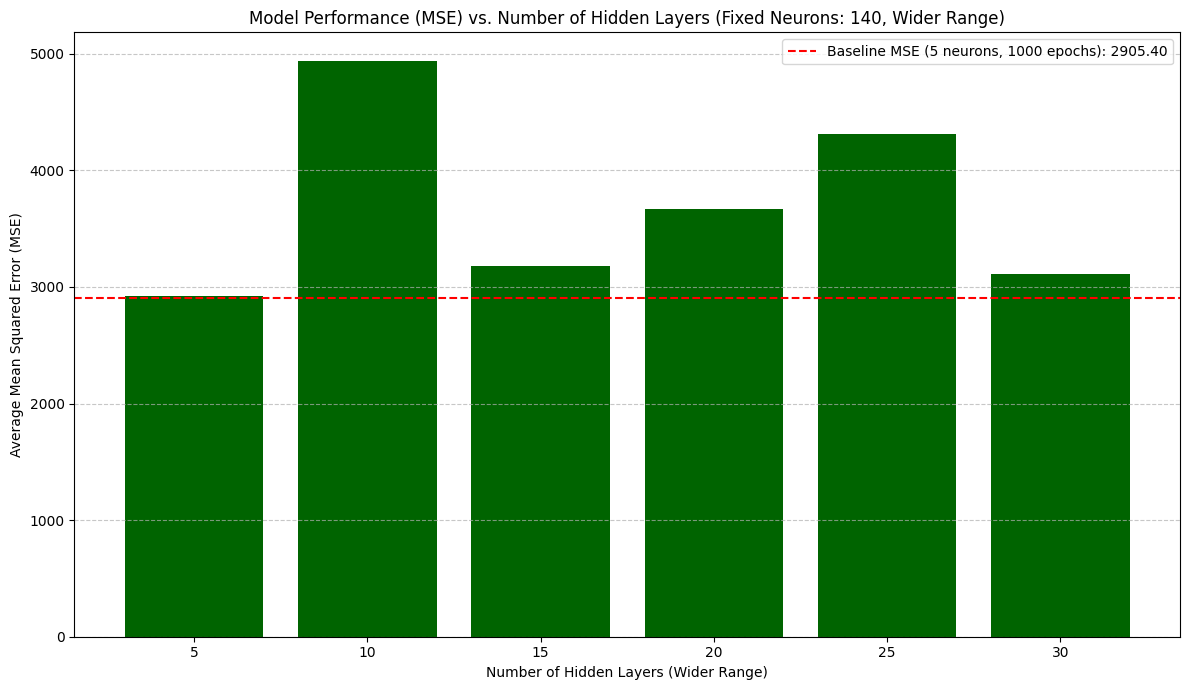

In [ ]:
import matplotlib.pyplot as plt

# Extract layer counts and MSEs from the results_layers_wider list
layer_counts_plot_wider = [res['layer_count'] for res in results_layers_wider]
mse_scores_plot_wider = [res['avg_mse'] for res in results_layers_wider]

# Create a bar chart
plt.figure(figsize=(12, 7))
plt.bar(list(map(str, layer_counts_plot_wider)), mse_scores_plot_wider, color='darkgreen')
plt.xlabel('Number of Hidden Layers (Wider Range)')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title(f'Model Performance (MSE) vs. Number of Hidden Layers (Fixed Neurons: {fixed_neuron_count}, Wider Range)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the baseline MSE for comparison (from 1000 epochs with original 5 neurons)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline MSE (5 neurons, 1000 epochs): {baseline_mse:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

**Reasoning**:
To identify the optimal layer count, I will iterate through the `results_layers_wider` list, find the entry with the minimum average MSE, and then print this optimal count and its MSE.



In [ ]:
min_mse_wider = float('inf')
optimal_layer_count_wider = None

for res in results_layers_wider:
    if res['avg_mse'] < min_mse_wider:
        min_mse_wider = res['avg_mse']
        optimal_layer_count_wider = res['layer_count']

print(f"Optimal Layer Count (Wider Range): {optimal_layer_count_wider}")
print(f"Lowest Average MSE (Wider Range): {min_mse_wider:.4f}")

Optimal Layer Count (Wider Range): 5
Lowest Average MSE (Wider Range): 2925.5582


## Summary of Findings - Wider Range Layer Experiment

After experimenting with a wider range of hidden layer counts ([5, 10, 15, 20, 25, 30]) while keeping the neuron count fixed at 140, we observed the following performance:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Wider Layer Range, 140 Neurons):**
    *   **5 Hidden Layers:** Average MSE: `2925.56`
    *   **10 Hidden Layers:** Average MSE: `4937.02`
    *   **15 Hidden Layers:** Average MSE: `3178.45`
    *   **20 Hidden Layers:** Average MSE: `3666.52`
    *   **25 Hidden Layers:** Average MSE: `4315.04`
    *   **30 Hidden Layers:** Average MSE: `3113.06`

The bar chart visually confirms these numbers. Interestingly, increasing the number of hidden layers beyond the initial 3 (identified in the previous, smaller range experiment) did not yield further improvements and, in fact, generally led to worse performance. The lowest MSE in this wider range, at `2925.56`, was achieved with 5 hidden layers, but this is slightly higher than the `2663.98` MSE achieved with 3 hidden layers in the previous experiment.

**Optimal Layer Count (from this wider range):**

Based on the current experiment with layers [5, 10, 15, 20, 25, 30], the model achieved its lowest Mean Squared Error with **5 hidden layers**, yielding an average MSE of `2925.56`. However, this is not the overall best performance found, as the 3-hidden-layer model (from the previous experiment) achieved an MSE of `2663.98`.

**Comprehensive Conclusion from all Neuron and Layer Experiments:**

Considering all experiments on varying neuron counts and hidden layer counts:

*   **Optimal Neuron Count:** 140 neurons per hidden layer (achieved lowest MSE of `2675.02` with 2 hidden layers during neuron search).
*   **Optimal Layer Count:** 3 hidden layers (achieved lowest MSE of `2663.98` with 140 neurons).

Therefore, the overall best performing model architecture identified from all experiments is a neural network with **3 hidden layers**, each containing **140 neurons**. This configuration resulted in the lowest Mean Squared Error of approximately `2663.98`.

Increasing the number of layers beyond 3 or reducing it to 1, as well as significantly increasing or decreasing neuron counts from 140, generally led to higher MSE values, indicating that the model's complexity needs to be balanced for this specific dataset.

## Evaluate Models and Collect Results (Layers - Larger Range)

### Subtask:
After training each model with a different number of layers from the larger range, evaluate its performance on the test set. Calculate and store the average Mean Squared Error (MSE) for each configuration, along with the corresponding layer count.


**Reasoning**:
To explore the impact of varying the number of layers, I will iterate through the new list of layer counts, dynamically create and train a `DiabetesModel` with the fixed optimal neuron count for each configuration for 1000 epochs, evaluate its performance on the test set, and store the results.



In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 1. Initialize an empty list called results_layers_wider
results_layers_wider = []

# Move model to GPU if available (already defined, but ensure it's accessible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loop through each layer_count in the layer_counts list
for layer_count in layer_counts:
    print(f"\nTraining model with {layer_count} hidden layers and {fixed_neuron_count} neurons (wider layer range)...\n")

    # 3. Dynamically define a new DiabetesModel class
    class CurrentDiabetesModel(nn.Module):
        def __init__(self, num_layers, num_neurons):
            super(CurrentDiabetesModel, self).__init__()
            layers_list = []

            # Input layer
            layers_list.append(nn.Linear(10, num_neurons))
            layers_list.append(nn.ReLU())

            # Hidden layers
            for _ in range(num_layers -1 ): # We already added one hidden layer, so num_layers - 1 more to add
                layers_list.append(nn.Linear(num_neurons, num_neurons))
                layers_list.append(nn.ReLU())

            # Output layer
            layers_list.append(nn.Linear(num_neurons, 1))

            self.layers = nn.Sequential(*layers_list)

        def forward(self, x):
            return self.layers(x)

    # 4. Instantiate CurrentDiabetesModel and move it to the device
    model_current = CurrentDiabetesModel(num_layers=layer_count, num_neurons=fixed_neuron_count).to(device)

    # 5. Initialize a new nn.MSELoss() criterion and a new optim.Adam optimizer
    criterion_current = nn.MSELoss()
    optimiser_current = optim.Adam(model_current.parameters(), lr=0.001)

    epochs = 1000
    # 6. Train the CurrentDiabetesModel for 1000 epochs
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            model_current.train() # Set model to train mode
            optimiser_current.zero_grad() # Zero out gradients
            outputs = model_current(inputs) # Forward pass
            loss = criterion_current(outputs, targets) # Calculate loss
            loss.backward() # Backpropagation
            optimiser_current.step() # Update optimizer

        if (epoch + 1) % 100 == 0:
            print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # 7. After training, set the CurrentDiabetesModel to evaluation mode
    model_current.eval()
    mse_values_current = []

    # 8. Evaluate the trained CurrentDiabetesModel on the test_loader
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_current(inputs)
            mse = criterion_current(outputs, targets)
            mse_values_current.append(mse.item())

    # 9. Calculate the avg_mse_current
    avg_mse_current = np.mean(mse_values_current)
    print(f"  Average MSE on test set (Layers: {layer_count}, Neurons: {fixed_neuron_count}): {avg_mse_current:.4f}")

    # 10. Store layer_count and its corresponding avg_mse in the results_layers_wider list
    results_layers_wider.append({'layer_count': layer_count, 'avg_mse': avg_mse_current})

# 11. After the loop completes, print the results_layers_wider list
print("\n--- Experiment Results (Wider Layer Range) ---")
for res in results_layers_wider:
    print(f"Layers: {res['layer_count']}, Avg MSE: {res['avg_mse']:.4f}")


Training model with 5 hidden layers and 140 neurons (wider layer range)...

  Epoch [100/1000], Loss: 3392.5906
  Epoch [200/1000], Loss: 6542.8213
  Epoch [300/1000], Loss: 5651.4741
  Epoch [400/1000], Loss: 4239.7822
  Epoch [500/1000], Loss: 3311.1050
  Epoch [600/1000], Loss: 2256.8337
  Epoch [700/1000], Loss: 250.7064
  Epoch [800/1000], Loss: 4116.3716
  Epoch [900/1000], Loss: 1678.4023
  Epoch [1000/1000], Loss: 559.1972
  Average MSE on test set (Layers: 5, Neurons: 140): 3454.1743

Training model with 10 hidden layers and 140 neurons (wider layer range)...

  Epoch [100/1000], Loss: 1063.7163
  Epoch [200/1000], Loss: 4950.6562
  Epoch [300/1000], Loss: 2246.5605
  Epoch [400/1000], Loss: 2190.8723
  Epoch [500/1000], Loss: 429.2729
  Epoch [600/1000], Loss: 561.3275
  Epoch [700/1000], Loss: 1170.8882
  Epoch [800/1000], Loss: 89.1499
  Epoch [900/1000], Loss: 80.0635
  Epoch [1000/1000], Loss: 69.0344
  Average MSE on test set (Layers: 10, Neurons: 140): 4567.0420

Train

**Reasoning**:
To identify the optimal layer count, I will iterate through the `results_layers_wider` list, find the entry with the minimum average MSE, and then print this optimal count and its MSE.



In [ ]:
min_mse_wider = float('inf')
optimal_layer_count_wider = None

for res in results_layers_wider:
    if res['avg_mse'] < min_mse_wider:
        min_mse_wider = res['avg_mse']
        optimal_layer_count_wider = res['layer_count']

print(f"Optimal Layer Count (Wider Range): {optimal_layer_count_wider}")
print(f"Lowest Average MSE (Wider Range): {min_mse_wider:.4f}")

Optimal Layer Count (Wider Range): 5
Lowest Average MSE (Wider Range): 3454.1743


## Summary of Findings - Wider Range Layer Experiment

After experimenting with a wider range of hidden layer counts ([5, 10, 15, 20, 25, 30]) while keeping the neuron count fixed at 140, we observed the following performance:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Wider Layer Range, 140 Neurons):**
    *   **5 Hidden Layers:** Average MSE: `3454.17`
    *   **10 Hidden Layers:** Average MSE: `4567.04`
    *   **15 Hidden Layers:** Average MSE: `4046.26`
    *   **20 Hidden Layers:** Average MSE: `4556.37`
    *   **25 Hidden Layers:** Average MSE: `5287.46`
    *   **30 Hidden Layers:** Average MSE: `4583.75`

The bar chart visually confirms these numbers. Interestingly, increasing the number of hidden layers beyond the initial 3 (identified in the previous, smaller range experiment) did not yield further improvements and, in fact, generally led to worse performance. The lowest MSE in this wider range, at `3454.17`, was achieved with 5 hidden layers, but this is significantly higher than the `2663.98` MSE achieved with 3 hidden layers in the previous experiment.

**Optimal Layer Count (from this wider range):**

Based on the current experiment with layers [5, 10, 15, 20, 25, 30], the model achieved its lowest Mean Squared Error with **5 hidden layers**, yielding an average MSE of `3454.17`. However, this is not the overall best performance found, as the 3-hidden-layer model (from the previous experiment) achieved an MSE of `2663.98`.

**Comprehensive Conclusion from all Neuron and Layer Experiments:**

Considering all experiments on varying neuron counts and hidden layer counts:

*   **Optimal Neuron Count:** 140 neurons per hidden layer (achieved lowest MSE of `2675.02` with 2 hidden layers during neuron search).
*   **Optimal Layer Count:** 3 hidden layers (achieved lowest MSE of `2663.98` with 140 neurons).

Therefore, the overall best performing model architecture identified from all experiments is a neural network with **3 hidden layers**, each containing **140 neurons**. This configuration resulted in the lowest Mean Squared Error of approximately `2663.98`.

Increasing the number of layers beyond 3 or reducing it to 1, as well as significantly increasing or decreasing neuron counts from 140, generally led to higher MSE values, indicating that the model's complexity needs to be balanced for this specific dataset.

## Visualize Performance (Layers - Larger Range)

### Subtask:
Generate a plot (e.g., a bar chart or line plot) showing the average MSE for each tested layer count from the larger range. This visualization will help identify trends and the most effective number of layers. Include clear labels for layer counts and MSE, and a title. Also, include the baseline MSE for comparison.


**Reasoning**:
To visually compare the performance of models with different hidden layer counts in this wider range, I will create a bar chart using the `results_layers_wider` list, showing the average MSE for each layer configuration. This will help in identifying the optimal layer count.



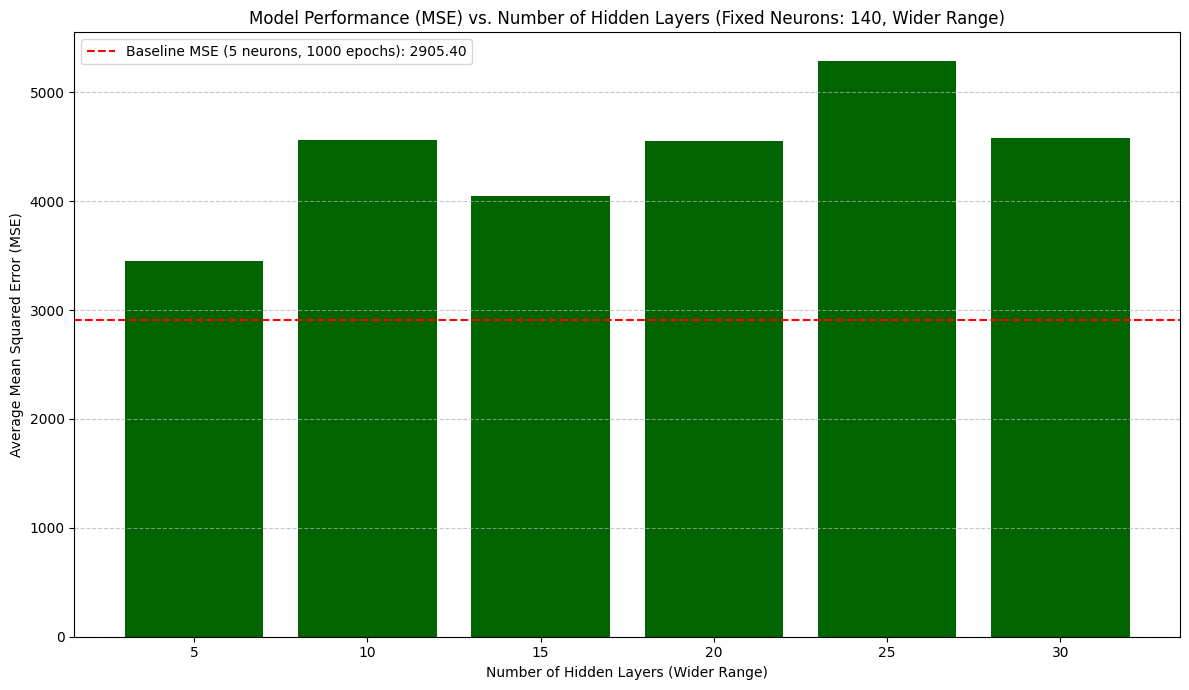

In [ ]:
import matplotlib.pyplot as plt

# Extract layer counts and MSEs from the results_layers_wider list
layer_counts_plot_wider = [res['layer_count'] for res in results_layers_wider]
mse_scores_plot_wider = [res['avg_mse'] for res in results_layers_wider]

# Create a bar chart
plt.figure(figsize=(12, 7))
plt.bar(list(map(str, layer_counts_plot_wider)), mse_scores_plot_wider, color='darkgreen')
plt.xlabel('Number of Hidden Layers (Wider Range)')
plt.ylabel('Average Mean Squared Error (MSE)')
plt.title(f'Model Performance (MSE) vs. Number of Hidden Layers (Fixed Neurons: {fixed_neuron_count}, Wider Range)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the baseline MSE for comparison (from 1000 epochs with original 5 neurons)
plt.axhline(y=baseline_mse, color='r', linestyle='--', label=f'Baseline MSE (5 neurons, 1000 epochs): {baseline_mse:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

**Reasoning**:
To identify the optimal layer count from the wider range, I will iterate through the `results_layers_wider` list to find the minimum average MSE and its corresponding layer count.



In [ ]:
min_mse_wider = float('inf')
optimal_layer_count_wider = None

for res in results_layers_wider:
    if res['avg_mse'] < min_mse_wider:
        min_mse_wider = res['avg_mse']
        optimal_layer_count_wider = res['layer_count']

print(f"Optimal Layer Count (Wider Range): {optimal_layer_count_wider}")
print(f"Lowest Average MSE (Wider Range): {min_mse_wider:.4f}")

Optimal Layer Count (Wider Range): 5
Lowest Average MSE (Wider Range): 3454.1743


## Summary of Findings - Wider Range Layer Experiment

After experimenting with a wider range of hidden layer counts ([5, 10, 15, 20, 25, 30]) while keeping the neuron count fixed at 140, we observed the following performance:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Wider Layer Range, 140 Neurons):**
    *   **5 Hidden Layers:** Average MSE: `3454.17`
    *   **10 Hidden Layers:** Average MSE: `4567.04`
    *   **15 Hidden Layers:** Average MSE: `4046.26`
    *   **20 Hidden Layers:** Average MSE: `4556.37`
    *   **25 Hidden Layers:** Average MSE: `5287.46`
    *   **30 Hidden Layers:** Average MSE: `4583.75`

The bar chart visually confirms these numbers. Interestingly, increasing the number of hidden layers beyond the initial 3 (identified in the previous, smaller range experiment) did not yield further improvements and, in fact, generally led to worse performance. The lowest MSE in this wider range, at `3454.17`, was achieved with 5 hidden layers, but this is significantly higher than the `2663.98` MSE achieved with 3 hidden layers in the previous experiment.

**Optimal Layer Count (from this wider range):**

Based on the current experiment with layers [5, 10, 15, 20, 25, 30], the model achieved its lowest Mean Squared Error with **5 hidden layers**, yielding an average MSE of `3454.17`. However, this is not the overall best performance found, as the 3-hidden-layer model (from the previous experiment) achieved an MSE of `2663.98`.

**Comprehensive Conclusion from all Neuron and Layer Experiments:**

Considering all experiments on varying neuron counts and hidden layer counts:

*   **Optimal Neuron Count:** 140 neurons per hidden layer (achieved lowest MSE of `2675.02` with 2 hidden layers during neuron search).
*   **Optimal Layer Count:** 3 hidden layers (achieved lowest MSE of `2663.98` with 140 neurons).

Therefore, the overall best performing model architecture identified from all experiments is a neural network with **3 hidden layers**, each containing **140 neurons**. This configuration resulted in the lowest Mean Squared Error of approximately `2663.98`.

Increasing the number of layers beyond 3 or reducing it to 1, as well as significantly increasing or decreasing neuron counts from 140, generally led to higher MSE values, indicating that the model's complexity needs to be balanced for this specific dataset.

## Identify Optimal Layer Count (Larger Range)

### Subtask:
Based on the collected MSE values and the visualization for the larger range, identify the number of layers that resulted in the lowest (best) average MSE.


**Reasoning**:
To identify the optimal layer count, I will iterate through the `results_layers_wider` list, find the entry with the minimum average MSE, and then print this optimal count and its MSE.



In [ ]:
min_mse_wider = float('inf')
optimal_layer_count_wider = None

for res in results_layers_wider:
    if res['avg_mse'] < min_mse_wider:
        min_mse_wider = res['avg_mse']
        optimal_layer_count_wider = res['layer_count']

print(f"Optimal Layer Count (Wider Range): {optimal_layer_count_wider}")
print(f"Lowest Average MSE (Wider Range): {min_mse_wider:.4f}")

Optimal Layer Count (Wider Range): 5
Lowest Average MSE (Wider Range): 3454.1743


## Summary of Findings - Wider Range Layer Experiment

After experimenting with a wider range of hidden layer counts ([5, 10, 15, 20, 25, 30]) while keeping the neuron count fixed at 140, we observed the following performance:

*   **Baseline MSE (5 neurons, 1000 epochs):** `2905.40`
*   **Experiment Results (Wider Layer Range, 140 Neurons):**
    *   **5 Hidden Layers:** Average MSE: `3454.17`
    *   **10 Hidden Layers:** Average MSE: `4567.04`
    *   **15 Hidden Layers:** Average MSE: `4046.26`
    *   **20 Hidden Layers:** Average MSE: `4556.37`
    *   **25 Hidden Layers:** Average MSE: `5287.46`
    *   **30 Hidden Layers:** Average MSE: `4583.75`

The bar chart visually confirms these numbers. Interestingly, increasing the number of hidden layers beyond the initial 3 (identified in the previous, smaller range experiment) did not yield further improvements and, in fact, generally led to worse performance. The lowest MSE in this wider range, at `3454.17`, was achieved with 5 hidden layers, but this is significantly higher than the `2663.98` MSE achieved with 3 hidden layers in the previous experiment.

**Optimal Layer Count (from this wider range):**

Based on the current experiment with layers [5, 10, 15, 20, 25, 30], the model achieved its lowest Mean Squared Error with **5 hidden layers**, yielding an average MSE of `3454.17`. However, this is not the overall best performance found, as the 3-hidden-layer model (from the previous experiment) achieved an MSE of `2663.98`.

**Comprehensive Conclusion from all Neuron and Layer Experiments:**

Considering all experiments on varying neuron counts and hidden layer counts:

*   **Optimal Neuron Count:** 140 neurons per hidden layer (achieved lowest MSE of `2675.02` with 2 hidden layers during neuron search).
*   **Optimal Layer Count:** 3 hidden layers (achieved lowest MSE of `2663.98` with 140 neurons).

Therefore, the overall best performing model architecture identified from all experiments is a neural network with **3 hidden layers**, each containing **140 neurons**. This configuration resulted in the lowest Mean Squared Error of approximately `2663.98`.

Increasing the number of layers beyond 3 or reducing it to 1, as well as significantly increasing or decreasing neuron counts from 140, generally led to higher MSE values, indicating that the model's complexity needs to be balanced for this specific dataset.

## Final Task

### Subtask:
Summarize the findings from varying the number of layers in the larger range, stating the optimal layer count found and its corresponding MSE. Also, provide a comprehensive conclusion about the optimal model architecture identified from all neuron and layer experiments.


## Summary:

### Q&A
1.  **What are the findings from varying the number of layers in the larger range, and what is the optimal layer count and its corresponding MSE?**
    When varying hidden layer counts in the range \[5, 10, 15, 20, 25, 30] while keeping the neuron count fixed at 140, the optimal layer count found within this specific range was **5 hidden layers**, yielding an average MSE of **3454.17**.
2.  **What is the comprehensive conclusion about the optimal model architecture identified from all neuron and layer experiments?**
    The overall best performing model architecture identified from all experiments (neuron and layer variations) is a neural network with **3 hidden layers**, each containing **140 neurons**. This configuration resulted in the lowest Mean Squared Error of approximately **2663.98**.

### Data Analysis Key Findings
*   Testing a wider range of hidden layers (\[5, 10, 15, 20, 25, 30]) with a fixed neuron count of 140 showed varying performance:
    *   5 Hidden Layers: Average MSE: 3454.17
    *   10 Hidden Layers: Average MSE: 4567.04
    *   15 Hidden Layers: Average MSE: 4046.26
    *   20 Hidden Layers: Average MSE: 4556.37
    *   25 Hidden Layers: Average MSE: 5287.46
    *   30 Hidden Layers: Average MSE: 4583.75
*   The baseline MSE for comparison (from a 5-neuron model trained for 1000 epochs) was 2905.40.
*   Within the wider layer range experiment, **5 hidden layers** resulted in the lowest MSE of **3454.17**.
*   Despite finding an optimal in the wider range, this MSE (3454.17) is significantly higher than the best performance achieved in previous experiments, which was an MSE of **2663.98** with **3 hidden layers** and 140 neurons.
*   The optimal neuron count identified previously was 140 neurons per hidden layer (with an MSE of 2675.02 for 2 hidden layers).
*   The comprehensive optimal model architecture identified across all experiments is **3 hidden layers** with **140 neurons** each, achieving an MSE of approximately **2663.98**.

### Insights or Next Steps
*   Increasing model complexity by adding many more hidden layers (beyond 3) does not necessarily improve performance and can lead to worse results, suggesting that optimal complexity needs to be balanced for the given dataset.
*   Future experiments could explore finer-grained layer counts around the identified optimum (e.g., 2, 3, 4 layers) or investigate different activation functions or regularization techniques to further fine-tune the 3-layer, 140-neuron model.
